In [1]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from iminuit import Minuit
from scipy import stats

from astropy.stats import poisson_conf_interval

In [2]:
exposure = .658 # ton-years

# Load the Data

Loading the data is performed in this utility method

In [3]:
def load():
    global energies, abc_ens, abc_flux, bkg_ens, bkg_flux
    
    
    data_archive = h5py.File('../Data/UnbinnedEvents.h5', 'r')

    cS1 = np.array(data_archive['cS1'])
    cS2 = np.array(data_archive['cS2'])

    data_archive.close()

    energies = (cS1 / .142 + cS2 / 11.4) * 13.8 / 1e3
    
    model_archive = h5py.File('../Data/ModelArchive.h5', 'r')

    abc_ens, abc_flux = np.array(model_archive['ABC_Model'])
    bkg_ens, bkg_flux = np.array(model_archive['Background_30keV'])

    model_archive.close()

# Set An Analysis Range and Construct PDFs

In [4]:
load()

emin = 1. # keV
emax = 9. # keV

energies = np.sort(energies[np.where(np.logical_and(energies >= emin, energies <= emax))])

interp_energies = np.linspace(emin, emax, int(1e6))

abc_interp = np.interp(interp_energies, abc_ens, abc_flux)
abc_interp_norm = abc_interp / np.trapz(abc_interp, interp_energies)

abc_pdf = interp1d(interp_energies, abc_interp_norm)

bkg_interp = np.interp(interp_energies, bkg_ens, bkg_flux)
bkg_interp_norm = bkg_interp / np.trapz(bkg_interp, interp_energies)

bkg_pdf = interp1d(interp_energies, bkg_interp_norm)
bkg_cts = np.trapz(bkg_interp, interp_energies)*exposure

# Construct and Maximize the Unbinned Likelihood

In [5]:
def NegLL(sig_cts):
    bkg_pdf_vals = bkg_pdf(energies)
    sig_pdf_vals = abc_pdf(energies)
    
    total_cts = sig_cts + bkg_cts
    
    probs = (bkg_cts / total_cts * bkg_pdf_vals + sig_cts / total_cts * sig_pdf_vals) 
    LL = np.sum(np.log(probs))+stats.poisson.logpmf(len(energies), total_cts)

    return -LL

In [6]:
m = Minuit(lambda x: 2*(NegLL(x)-NegLL(0)), x = 0, limit_x = [0, None], error_x = 1, errordef = 1e0)
m.migrad()

------------------------------------------------------------------
| FCN = -11.94                  |      Ncalls=51 (51 total)      |
| EDM = 2.94E-09 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x    |    52     |    17     |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

# Plot the Fit and Binned Counts

In [7]:
counts, edges = np.histogram(energies, bins = np.linspace(emin, emax, 2*round(emax - emin)+1))
centers = (edges[1:] + edges[:-1])/2

errors = poisson_conf_interval(counts, interval='frequentist-confidence')
errors[0] = counts - errors[0]
errors[1] = errors[1] - counts

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


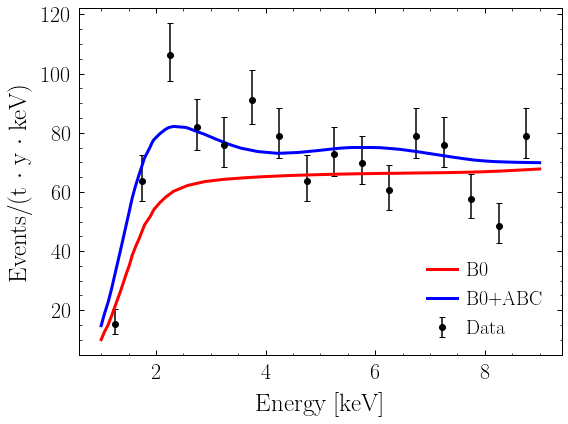

In [8]:
# Figure size
mpl.rcParams['figure.figsize'] = 8, 6


plt.errorbar(centers, counts / np.diff(centers)[0]/exposure, yerr = (errors)/exposure,
             fmt = 'o', color = 'black', capsize = 3, label = 'Data')

plt.plot(interp_energies, bkg_cts*bkg_interp_norm / exposure, c = 'red', lw = '3', label = 'B0')
plt.plot(interp_energies, bkg_cts*bkg_interp_norm / exposure + m.values['x']*abc_interp_norm / exposure,
          c = 'blue', lw = '3', label = 'B0+ABC')
plt.ylabel(r'Events/(t $\cdot$ y $\cdot$ keV)')
plt.xlabel('Energy [keV]')

plt.legend(fontsize = 20, loc = 'lower right', ncol = 1, frameon = False)
plt.tight_layout()
plt.savefig('../Plots/Fig4.pdf')
plt.show()